In [80]:
import numpy as np
import gudhi
import matplotlib.pyplot as plt
from mnist_loader import load_data
from sklearn.manifold import MDS
import cv2
import gudhi.hera
import pickle
from tqdm import tqdm

In [88]:
from sklearn.metrics import euclidean_distances
from scipy.optimize import linear_sum_assignment

def weightedW(P, Q):
    if len(P) == 0 and len(Q) == 0:
        return 0
    PP = [x for x in P]
    QQ = [x for x in Q]
    PP.extend([[(x[0]+x[1])/2, (x[0]+x[1])/2] for x in Q])
    QQ.extend([[(x[0]+x[1])/2, (x[0]+x[1])/2] for x in P])
    PP = np.array(PP)
    QQ = np.array(QQ)
    M1 = np.abs(PP[:,0][:, None] - QQ[:,0][None, :])
    M2 = np.abs(PP[:,1][:, None] - QQ[:,1][None, :])
    M = np.max([M1, M2], axis=0)
    M[len(P):,:][:,len(Q):] = 0
    W = ( (PP@np.array([-1,1]))[:, None] + (QQ@np.array([-1,1]))[None, :])/(2*np.sqrt(2))
    row_ind, col_ind = linear_sum_assignment(M*W)
    return (M*W)[row_ind, col_ind].sum()

def vineyardDistance(PDs):
    ds = [weightedW(PDs[i], PDs[i+1]) for i in range(len(PDs)-1)]
    return sum(ds)

def get_PD(img):
    ccx = gudhi.CubicalComplex(top_dimensional_cells=1-img.reshape(28,28))
    ccx.compute_persistence()
    return ccx.persistence_intervals_in_dimension(1)

def W1(pd1, pd2):
    return gudhi.hera.wasserstein_distance(pd1, pd2, order=1., internal_p=1.)

def VD(img1, img2):
    in_betweens = interpolate(img1, img2)
    PDs = [get_PD(img) for img in in_betweens]
    return vineyardDistance(PDs)

def interpolate(A,B, npoints=10):
    A = np.array(A)
    B = np.array(B)
    return [A + (B - A) * t for t in np.linspace(0, 1, npoints)]


In [ ]:
np.random.seed(2025)

train, valid, test = load_data()

# Collect images of digits 6 and 9 from the datasets
imgs6 = [x for x,y in zip(train[0], train[1]) if y == 6]
imgs9 = [x for x,y in zip(train[0], train[1]) if y == 9]
imgs7 = [x for x,y in zip(train[0], train[1]) if y == 7]
imgs6 += [x for x,y in zip(valid[0], valid[1]) if y == 6]
imgs9 += [x for x,y in zip(valid[0], valid[1]) if y == 9]
imgs7 += [x for x,y in zip(valid[0], valid[1]) if y == 7]
imgs6 += [x for x,y in zip(test[0], test[1]) if y == 6]
imgs9 += [x for x,y in zip(test[0], test[1]) if y == 9]
imgs7 += [x for x,y in zip(test[0], test[1]) if y == 7]
imgs6 = np.array(imgs6)
imgs9 = np.array(imgs9)
imgs7 = np.array(imgs7)

# Subsample to 100 random images
imgs6 = imgs6[np.random.choice(imgs6.shape[0], size=100, replace=False)]
imgs9 = imgs9[np.random.choice(imgs9.shape[0], size=100, replace=False)]
imgs7 = imgs7[np.random.choice(imgs7.shape[0], size=100, replace=False)]
imgs = np.concatenate([imgs6, imgs9, imgs7])
labels = [6] * 100 + [9] * 100 + [7] * 100

/opt/miniconda3/envs/work311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


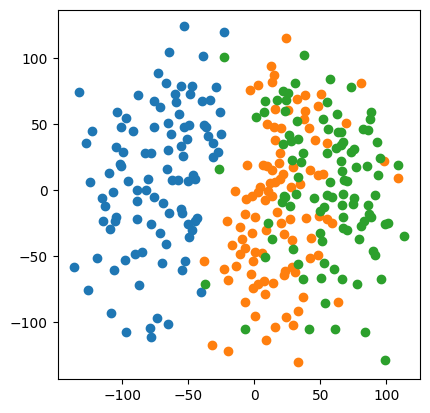

In [96]:
M_L1 = np.linalg.norm(imgs[:, None] - imgs[None, :], ord=1, axis=-1)
Y = MDS(n_components=2, dissimilarity='precomputed', random_state=2025).fit_transform(M_L1)
plt.scatter(Y[:100, 0], Y[:100, 1], label='6')
plt.scatter(Y[100:200, 0], Y[100:200, 1], label='9')
plt.scatter(Y[200:, 0], Y[200:, 1], label='7')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('digits697_M_L1.png', bbox_inches='tight', dpi=150)

100%|██████████| 300/300 [00:01<00:00, 193.21it/s]
/opt/miniconda3/envs/work311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


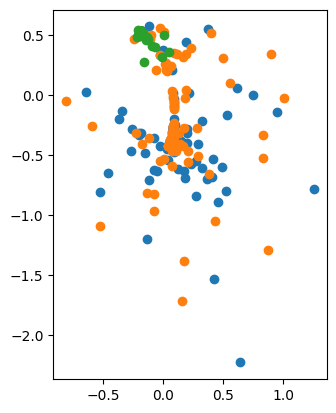

In [95]:
PDs = [get_PD(img) for img in imgs]

M_W1 = np.zeros((len(imgs), len(imgs)))
for i, pd1 in tqdm(enumerate(PDs), total=len(PDs)):
    for j, pd2 in enumerate(PDs):
        M_W1[i, j] = W1(pd1, pd2)

pickle.dump(M_W1, open("M_W1.pkl", "wb"))
M_W1 = pickle.load(open("M_W1.pkl", "rb"))
Y = MDS(n_components=2, dissimilarity='precomputed', random_state=2025).fit_transform(M_W1)
plt.scatter(Y[:100, 0], Y[:100, 1], label='6')
plt.scatter(Y[100:200, 0], Y[100:200, 1], label='9')
plt.scatter(Y[200:, 0], Y[200:, 1], label='7')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('digits697_M_W1.png', bbox_inches='tight', dpi=150)

/opt/miniconda3/envs/work311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


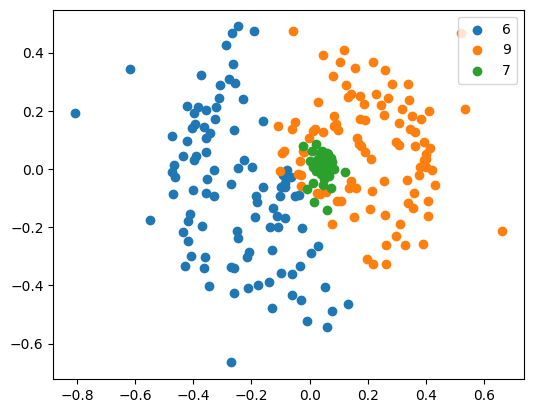

In [ ]:
M_VD = np.zeros((len(imgs), len(imgs)))
for i, pd1 in tqdm(enumerate(imgs), total=len(imgs)):
    for j, pd2 in enumerate(imgs):
        M_VD[i, j] = VD(imgs[i], imgs[j])
pickle.dump(M_VD, open("M_VD.pkl", "wb"))
M_VD = pickle.load(open("M_VD.pkl", "rb"))
M_VD = (M_VD + M_VD.T) / 2
Y = MDS(n_components=2, dissimilarity='precomputed', random_state=2025).fit_transform(M_VD)
plt.scatter(Y[:100, 0], Y[:100, 1], label='6')
plt.scatter(Y[100:200, 0], Y[100:200, 1], label='9')
plt.scatter(Y[200:, 0], Y[200:, 1], label='7')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper right')
plt.savefig('digits697_M_VD.png', bbox_inches='tight', dpi=150)